In [2]:
#导入模型计算基本包
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.optim import Adam
from einops import rearrange
#图像及模型处理
from d2l import torch as d2l
import torchvision.models as models
import torchvision
#评估绘图包
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
#文件路径设置
data_dir = '../../数据/XRay_lung'#设置文件读取路径
save_dir = './model_ViT_XRay_lung.pt'#设置保存路径

In [3]:
#设置参数
device = d2l.try_gpu()#设置运行模式：CPU/GPU
batch_size, lr, num_epochs = 8, 0.00005, 100#设置批量、学习率和迭代次数
image_size = 512#将所有图片统一转换的大小
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((image_size, image_size)),
                                            torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5,),(0.5,),(0.5,))])#图像归一化方式
input_shape = (3, image_size, image_size)
num_patches, dim, depth, heads, mlp_dim = 32, 64, 6, 8, 128#保证num_patches可整除image_shape
#在网络参数方面，使用了 64 个单元的维度，6 个 Transformer 块的深度，8 个 Transformer 头，MLP 使用 128 维度
num_classes = 4#输出类别数量

#设置随机数种子
np.random.seed(42)
torch.manual_seed(42)

In [4]:
#残差模块，放在每个前馈网络和注意力之后
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

In [5]:
#layernorm归一化,放在多头注意力层和激活函数层。用绝对位置编码的BERT，layernorm用来自身通道归一化
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [6]:
#放置多头注意力后，因为在于多头注意力使用的矩阵乘法为线性变换，后面跟上由全连接网络构成的FeedForward增加非线性结构
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

In [7]:
#多头注意力层，多个自注意力连起来。使用qkv计算
class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [8]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

In [9]:
#将图像切割成一个个图像块,组成序列化的数据输入Transformer执行图像分类任务。
class ViT(nn.Module):
    def __init__(self, input_shape, num_patches, num_classes, dim=64, depth=6, heads=8, mlp_dim=128):
        super().__init__()
        channels, image_size, image_size0 = input_shape
        assert input_shape[1] % num_patches == 0, "图像边长无法被num_patches整除"
        patch_size = int(input_shape[1] / num_patches)
        patch_dim = channels * patch_size ** 2
        num_patches = num_patches ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [10]:
#精度评估函数
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [11]:
#训练函数
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = Adam(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [12]:
#绘制多分类ROC曲线
def plot_multiclass_roc_curve(model, test_iter):
    # 获取模型的预测概率和真实标签
    y_true = []
    y_prob = []
    for batch in test_iter:
        inputs, labels = batch
        inputs = inputs.cuda()
        outputs = model(inputs)
        probabilities = outputs.softmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probabilities.cpu().detach().numpy())
    y_true = np.array(y_true)
    y_prob = np.argmax(y_prob,axis=1)
    y_prob = np.array(y_prob)

    #微平均和宏平均方法（Micro-average and Macro-average）
    # 将真实标签转换为二值矩阵
    y_true = label_binarize(y_true, classes=np.unique(y_true))
    y_prob = label_binarize(y_prob, classes=np.unique(y_prob))

    # 将多分类问题转换为二分类问题
    y_true = y_true.ravel()
    y_prob = y_prob.ravel()

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # 绘制ROC曲线
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
def main():
    #数据处理
    train_path = data_dir + '/training'
    test_path = data_dir + '/testing'
    
    train_data = torchvision.datasets.ImageFolder(train_path,transform=transform)
    test_data = torchvision.datasets.ImageFolder(test_path,transform=transform)

    train_iter=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
    test_iter=torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True)
    
    #定义模型和训练模块
    model = ViT(input_shape, num_patches, num_classes, dim, depth, heads, mlp_dim)

    #训练
    train(model, train_iter, test_iter, num_epochs, lr, device)
    
    #保存模型
    torch.save(model,save_dir)

    #调用模型计算ROC曲线
    plot_multiclass_roc_curve(model, test_iter)

loss 0.029, train acc 0.991, test acc 0.900
51.8 examples/sec on cuda:0


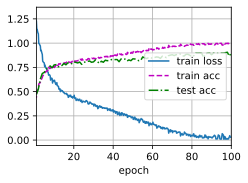

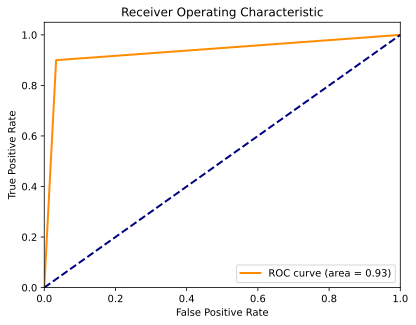

In [14]:
if __name__ == '__main__':
    main()

In [3]:
%reset
torch.cuda.empty_cache()  # 释放显存

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


NameError: name 'torch' is not defined